In [7]:

# Tensorflow Libraries
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from keras.optimizers import Adam

import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Attention, Rescaling
from keras.models import Model
from keras.layers import Input
# System libraries
from pathlib import Path
import os.path
gpus = tf.config.experimental.list_physical_devices('GPU.0')
if gpus:
    try:
        # 假设您的 GPU 有 10GB 显存，设置稍大于 10GB 的显存限制
        memory_limit = 3,584  # 以 MB 为单位
        config = tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(gpu, [config])
    except RuntimeError as e:
        print(e)

In [4]:
import os
import random
from shutil import copy2


def data_set_split(initial_data_folder, target_data_folder, train_scale=0.8, val_scale=0.1, test_scale=0.1):


    class_names = os.listdir(initial_data_folder)
    split_names = ['train', 'val', 'test']
    for split_name in split_names:
        split_path = os.path.join(target_data_folder, split_name)
        if os.path.isdir(split_path):
            pass
        else:
            os.mkdir(split_path)
        for class_name in class_names:
            class_split_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_split_path):
                pass
            else:
                os.mkdir(class_split_path)


    for class_name in class_names:
        current_class_data_path = os.path.join(initial_data_folder, class_name)
        current_all_data = os.listdir(current_class_data_path)
        current_data_length = len(current_all_data)
        current_data_index_list = list(range(current_data_length))
        random.shuffle(current_data_index_list)

        train_folder = os.path.join(os.path.join(target_data_folder, 'train'), class_name)
        val_folder = os.path.join(os.path.join(target_data_folder, 'val'), class_name)
        test_folder = os.path.join(os.path.join(target_data_folder, 'test'), class_name)
        train_stop_flag = current_data_length * train_scale
        val_stop_flag = current_data_length * (train_scale + val_scale)
        current_idx = 0
        train_num = 0
        val_num = 0
        test_num = 0
        for i in current_data_index_list:
            initial_img_path = os.path.join(current_class_data_path, current_all_data[i])
            if current_idx <= train_stop_flag:
                copy2(initial_img_path, train_folder)

                train_num = train_num + 1
            elif (current_idx > train_stop_flag) and (current_idx <= val_stop_flag):
                copy2(initial_img_path, val_folder)

                val_num = val_num + 1
            else:
                copy2(initial_img_path, test_folder)

                test_num = test_num + 1

            current_idx = current_idx + 1


if __name__ == '__main__':
    initial_data_folder = "picture"
    target_data_folder = "datasets"
    data_set_split(initial_data_folder, target_data_folder)

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
from time import *

def generate_ensemble_data(generator):
    while True:
        x, y = generator.next()
        yield [x, x], y
train_dir = r"E:\3\coursework\datasets\train"
valid_dir = r"E:\3\coursework\datasets\val"
test_dir =  r"E:\3\coursework\datasets\test"
TARGET_SIZE = (224,224)
BATCH_SIZE = 12
datagen = ImageDataGenerator(

)
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)


val_generator = datagen.flow_from_directory(
    valid_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=TARGET_SIZE,
    batch_size= BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)
train_ensemble_generator = generate_ensemble_data(train_generator)
val_ensemble_generator = generate_ensemble_data(val_generator)
test_ensemble_generator = generate_ensemble_data(test_generator)

train_steps = train_generator.samples // train_generator.batch_size
val_steps = val_generator.samples // val_generator.batch_size
test_steps = test_generator.samples // test_generator.batch_size



Found 5171 images belonging to 12 classes.
Found 1287 images belonging to 12 classes.
Found 1306 images belonging to 12 classes.


In [ ]:
def loss(y_true, y_pred):
  # 将输入转换为浮点数
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  # 计算损失
  loss = tf.math.log(1 + tf.math.exp(-(y_true * y_pred)))
  # 返回损失的平均值
  return tf.reduce_mean(loss)

In [10]:
from keras.layers import BatchNormalization
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 7,
                               restore_best_weights = True)
# if val loss decreases for 3 epochs in a row, stop training
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras.layers import Rescaling
input_shape = Input(shape=(224,224,3))
# 创建一个缩放层对象，把输入的图像缩放到0到1的范围
x2 = Conv2D(32, 3, padding='same', activation='relu')(input_shape)
x2 = MaxPool2D(2, 2)(x2)
x2 = BatchNormalization()(x2)
x2 = Conv2D(64, 3, padding='same', activation='relu')(x2)
x2 = Attention(use_scale=True)([x2, x2])
x2 = MaxPool2D(2, 2)(x2)
x2 = BatchNormalization()(x2)
x2 = Conv2D(128, 3, padding='same', activation='relu')(x2)
x2 = Attention(use_scale=True)([x2, x2])
x2 = MaxPool2D(2, 2)(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.2)(x2)
x2 = Flatten()(x2)
output = Dense(12, activation='softmax', name='output')(x2)
model1 = Model(inputs=input_shape, outputs=[output])
model1.summary()
model1.compile(optimizer='adam', loss='loss', metrics=['accuracy'])
model1.compile(
    optimizer=Adam(0.00001),
    loss=loss(),
    metrics=['accuracy']
)
# train_ds, val_ds, class_names = data_load(r"E:\3\coursework\dataset\test",
#                                             r"E:\3\coursework\datasets\val", 224, 224, 32)
# history = model1.fit(train_ds, validation_data=val_ds, epochs=100 ,callbacks=[
#         early_stopping,
#     ])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 112, 112, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [11]:
from keras.layers import ReLU
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Add

def res_block(input_shape, filters, strides=1):
    #
    shortcut = input_shape

    x1 = Conv2D(filters, (1,1), strides=1, padding='same')(input_shape)
    x1 = BatchNormalization()(x1)
    x1 = ReLU()(x1)
    x1 = Conv2D(filters, (3,3), padding='same')(x1)
    x1= BatchNormalization()(x1)
    x1 = ReLU()(x1)

    x1= Conv2D(filters*4, (1,1), padding='same')(x1)
    x1 = BatchNormalization()(x1)
    # Skip connection
    if strides !=1 or shortcut.shape[-1]!= filters*4:
        shortcut = Conv2D(filters*4, (1,1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    # Add the shortcut to the main path
    x1 = Add()([x1, shortcut])
    x1 = ReLU()(x1)

    return x1

In [12]:

from keras.layers import MaxPooling2D

input_shape = Input(shape=(224,224,3))
# Use a tuple instead of a tensor for input_shape
x1 = Conv2D(64, (7,7), strides=2, padding='same')(input_shape)
x1 = BatchNormalization()(x1)
x1 = ReLU()(x1)
x1 = res_block(x1, filters=32, strides=1)
x1 = MaxPooling2D(2,2)(x1)
x1 = res_block(x1, filters=32, strides=1)
x1 = MaxPooling2D(2,2)(x1)
x1 = GlobalAveragePooling2D()(x1)
output = Dense(12, activation='softmax')(x1)
model_2 = Model(inputs=input_shape, outputs=output)
model_2.summary()
# history = model_2.fit(train_ds, validation_data=val_ds, epochs=100 , callbacks=[
#         early_stopping,
#     ])
# history = model_2.fit(
#     train_images,
#     steps_per_epoch=len(train_images),
#     validation_data=val_images,
#     validation_steps=len(val_images),
#     epochs=100,
#     callbacks=[
#
#         early_stopping,
#     ]
# )



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 112, 112, 64  256        ['conv2d_3[0][0]']               
 rmalization)                   )                                                           

In [5]:
from keras.layers import concatenate
input1 = Input(shape=(224, 224, 3))
input2 = Input(shape=(224, 224, 3))
concatenated_output = concatenate([model1.output, model_2.output])
x = Dense(100, activation='relu')(concatenated_output)
ensemble_model = Dense(12, activation='softmax')(x)
model = Model(inputs=[model1.input, model_2.input], outputs=ensemble_model)
model.summary()
model.compile(
    optimizer=Adam(0.001),
    loss=loss(),
    metrics=['accuracy',tf.keras.metrics.Recall(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.SpecificityAtSensitivity(0.90),]
)
logdir="logs/fit/"
csv_logger = keras.callbacks.CSVLogger("training.csv", separator=",", append=False)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
model_checkpoint = keras.callbacks.ModelCheckpoint("best_model1.h5", save_best_only=True)
history = model.fit(
    train_ensemble_generator,
    epochs=500,
    validation_data=val_ensemble_generator,
    validation_steps=val_steps,
    steps_per_epoch=train_steps,
    callbacks=[tensorboard_callback,model_checkpoint,csv_logger]
)
model.save("results/cnn_6.h5")
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


Epoch 1/500
430/430 [==============================] - 56s 119ms/step - loss: 0.1449 - accuracy: 0.9539 - recall: 0.9500 - precision: 0.9574 - specificity_at_sensitivity: 0.9985 - val_loss: 1.0077 - val_accuracy: 0.8326 - val_recall: 0.8279 - val_precision: 0.8383 - val_specificity_at_sensitivity: 0.9635
Epoch 2/500
430/430 [==============================] - 52s 117ms/step - loss: 0.1260 - accuracy: 0.9589 - recall: 0.9554 - precision: 0.9629 - specificity_at_sensitivity: 0.9989 - val_loss: 0.8429 - val_accuracy: 0.8551 - val_recall: 0.8520 - val_precision: 0.8689 - val_specificity_at_sensitivity: 0.9741
Epoch 3/500
430/430 [==============================] - 50s 117ms/step - loss: 0.1179 - accuracy: 0.9641 - recall: 0.9614 - precision: 0.9672 - specificity_at_sensitivity: 0.9989 - val_loss: 0.7455 - val_accuracy: 0.8925 - val_recall: 0.8879 - val_precision: 0.8991 - val_specificity_at_sensitivity: 0.9876
Epoch 4/500
430/430 [==============================] - 50s 117ms/step - loss: 0.12

KeyboardInterrupt: 

Found 1306 images belonging to 12 classes.
19/19 [==============================] - 2s 87ms/step


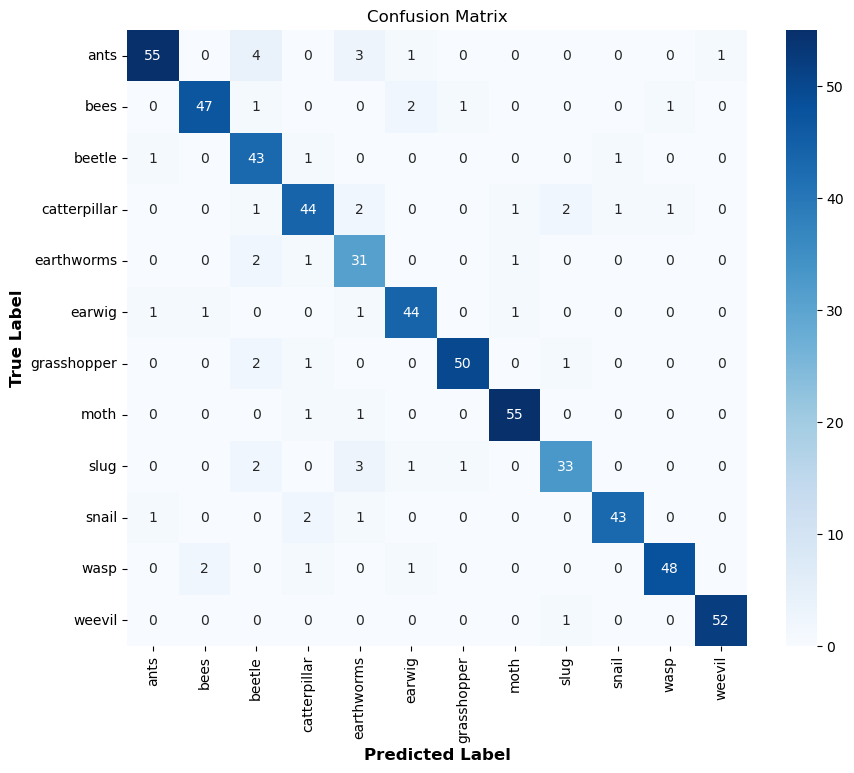

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [15]:
from seaborn import heatmap
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt
def test_cnn():
    model = tf.keras.models.load_model(r"E:\3\coursework\best_model1.h5")
    from sklearn.metrics import confusion_matrix
    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=TARGET_SIZE,
        batch_size=600,
        class_mode='categorical',
        color_mode='rgb'
    )
    class_names = ["ants", "bees", "beetle","catterpillar", "earthworms", "earwig","grasshopper", "moth", "slug","snail", "wasp", "weevil"]
    x,y =test_generator.next()
    model.evaluate(test_ensemble_generator,steps = test_steps)
    y_probs = model.predict([x,x])
    y_pred = np.argmax(y_probs, axis=1)
    y_true_classes = np.argmax(y, axis=1)  # 如果y_true是独热编码的，则需要转换为类别
    cm = confusion_matrix(y_true_classes, y_pred)
    plt.figure(figsize=(10, 8))
    heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.show()
    f1 = f1_score(y_pred,y)
    print(f1)
if __name__ == '__main__':
    test_cnn()
